## How decision trees behave with different types of encoding
This example comes from [here](https://github.com/groverpr/Machine-Learning/blob/master/catboost/ohc_dtreeviz.ipynb)

In [3]:
from sklearn.datasets import *
from sklearn import tree
from dtreeviz.trees import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [4]:
binary_feature_with_high_cardinality = np.random.randint(0, 100, 1000)  # 100 cateogries for 1000 observations
X = pd.DataFrame({"x": binary_feature_with_high_cardinality})

# target_labels = np.random.binomial(1, 0.5, size=1000)  # 0 or 1 with 50-50 ratio

In [5]:
np.linspace(0,99,10)

array([ 0., 11., 22., 33., 44., 55., 66., 77., 88., 99.])

In [6]:
target = []
for i in binary_feature_with_high_cardinality:
    if i in np.linspace(0,99,10):
        target.append(1)
    else: 
        target.append(0)
        
target = np.array(target)

In [7]:
sum(target)

114

### Label encoding
Nothing to do here

In [68]:
classifier = tree.DecisionTreeClassifier(max_depth=5)  # limit depth of tree
classifier.fit(X, target)

viz = dtreeviz(classifier, 
               X, 
               target,
               target_name='target',
              feature_names= ['feature'],
              class_names = ["label-0", "label-1"]  # need class_names for classifier
              )  
              
viz.view()

### One Hot Encoding

In [52]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X_ohc = enc.transform(X)
X_ohc = pd.DataFrame(X_ohc.toarray())

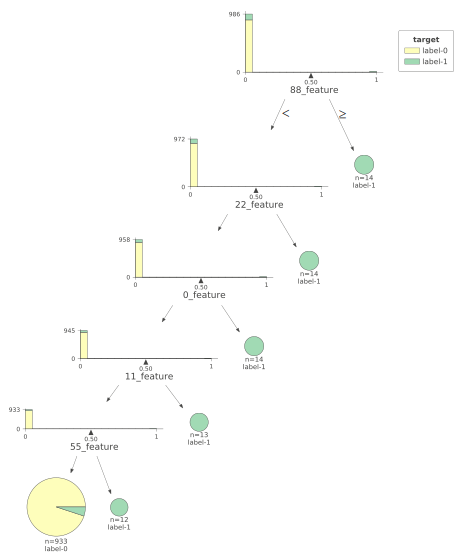

In [64]:
classifier = tree.DecisionTreeClassifier(max_depth=5)  # limit depth of tree
classifier.fit(X_ohc.values, target)

viz = dtreeviz(classifier, 
               X_ohc, 
               target,
               target_name='target',
              feature_names= [f'{c}_feature' for c in X_ohc.columns],
              class_names = ["label-0", "label-1"]  # need class_names for classifier
              )  
              
viz

### K-Fold Target Encoding

In [54]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import KFold

In [55]:
def target_encoder_regularized(train, cols_encode, target, folds=4):
    """
    Mean regularized target encoding based on kfold
    """

    kf = KFold(n_splits=folds, random_state=1)

    for col in cols_encode:
        global_mean = train[target].mean()

        for train_index, test_index in kf.split(train):
            mean_target = train.iloc[train_index].groupby(col)[target].mean()
            train.loc[test_index, col + "_mean_enc"] = train.loc[test_index, col].map(mean_target)
        train[col + "_mean_enc"].fillna(global_mean, inplace=True)
    return train

In [94]:
X_encode = target_encoder_regularized(pd.concat([X, pd.DataFrame({"y":target})], axis=1), "x", "y")
X_encode = pd.DataFrame({"x": X_encode["x_mean_enc"]})

In [99]:
encoder = TargetEncoder(cols="x")
encoder.fit(X, target)
X_encode = encoder.transform(X, target)

In [100]:
classifier = tree.DecisionTreeClassifier(max_depth=5)  # limit depth of tree
classifier.fit(X_encode, target)

viz = dtreeviz(classifier, 
               X_encode, 
               target,
               target_name='target',
              feature_names= X_encode.columns, 
              class_names = ["label-0", "label-1"]  # need class_names for classifier
              )  
              
viz.view()

### Catboost Encoding

In [60]:
def catboost_target_encoder(train, cols_encode, target):
    train_new = train.copy()
    for column in cols_encode:
        global_mean = train[target].mean()
        cumulative_sum = train.groupby(column)[target].cumsum() - train[target]
        cumulative_count = train.groupby(column).cumcount()
        train_new[column + "_cat_mean_target"] = cumulative_sum/cumulative_count
        train_new[column + "_cat_mean_target"].fillna(global_mean, inplace=True)
    return train_new

In [61]:
X_cat = catboost_target_encoder(pd.concat([X, pd.DataFrame({"y":target})], axis=1), "x", "y")
X_cat = pd.DataFrame({"x": X_cat["x_cat_mean_target"]})

In [65]:
classifier = tree.DecisionTreeClassifier(max_depth=5)  # limit depth of tree
classifier.fit(X_cat, target)

viz = dtreeviz(classifier, 
               X_cat, 
               target,
               target_name='target',
              feature_names= "x", 
              class_names = ["label-0", "label-1"]  # need class_names for classifier
              )  
              
viz.view()